In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from scipy import stats
from scipy import signal
from statsmodels.graphics.api import qqplot

import os
import sys #only needed to determine the python version number
import matplotlib #only needed to determine Matplotlib version number

# Enable inline plotting (notebook plotting )
%matplotlib inline
print("Python version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Statsmodels version: {}".format(sm.version.version))
print("Matplotlib version: {}".format(matplotlib.__version__))

Python version: 3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]
Pandas version: 0.22.0
Statsmodels version: 0.8.0
Matplotlib version: 2.2.2


# A Visual Tour of Time Series:



This presentation will look at the step between data cleaning and modeling of a time series.  We will look at the tools available to visually explore the data in preparation for modeling or forecasting the time series.

We will attempt to provide some guidance a variety of approaches available for ascertaining some properties of a given time series.  Are you ready?  Then let's get started.

## Visual Tools for Exploratory Analysis

Typically when one is faced with a time series, they start with plotting the time series.  What should be looked for in the plot?
* Variance: Is the variance constant or changing?
* Patterns: Trends, cycles, seasonality
* Outliers that could impact the results.  One might want to model with and without the outliers to see what impact these have upon the model.
* Sudden Changes in mean, variance or other properties of the time series


Examples:
Let's read in the CO2 database provided by statsmodels.

In [2]:
co2_dataset = sm.datasets.co2.load_pandas()
df1 = co2_dataset.data

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
co2    2225 non-null float64
dtypes: float64(1)
memory usage: 35.7 KB


In [4]:
df1.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [5]:
df1.tail()

,co2
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3
2001-12-29,371.5


In [6]:
df1.describe()

,co2
count,2225.000000
mean,340.142247
std,17.003885
min,313.000000
25%,324.800000
50%,338.300000
75%,354.800000
max,373.900000


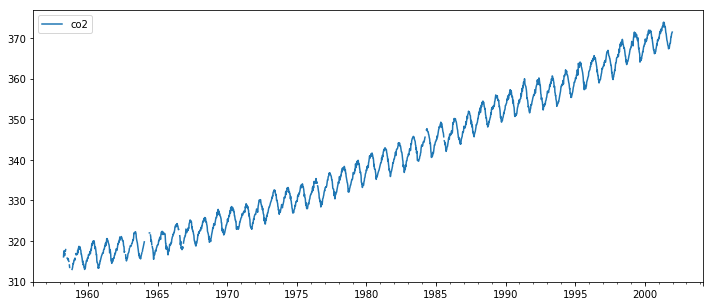

In [7]:
df1.plot(figsize=(12,5))

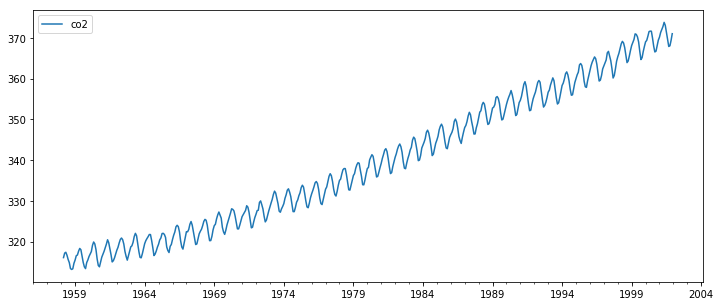

In [8]:
df_co2i = df1.loc[:,['co2']].interpolate()
df_co2ms = df_co2i.resample('MS').mean()
df_co2ms.plot(figsize=(12,5))

It is obvious that there is a both a trend and a seasonal component.  Therefore this time series is not stationary.  There are analytical checks one can make to determine the likelihood that the observed time series is stationary.

Let's look at ways to better visualize these components of this time series.  Often people will start with the basics.  They will plot the rolling mean and the rolling standard deviation.

If the rolling mean is varying, then the time series is not stationary.  Also if the rolling standard deviation is not stable, then the the time series is not stationary.  This is important to check when you are choosing a model.  Often the models you will work with assume the underlying time series is stationary.

In [9]:
def rolling_mean(tseries, window=30, title='', figsize=(14, 8)):
    '''Plot a time series along with its rolling mean'''
    
    fig = plt.figure(figsize=figsize)
    ts_ax = tseries.plot()
    ts_ax.set_title(title)
    rolling = tseries.rolling(window, center=True)
    rolling.mean().plot(ax=ts_ax)
    plt.tight_layout()
    plt.show()
    
def rolling_std(tseries, window=30, title='', figsize=(14, 8)):
    '''Plot a time series along with its rolling stddev'''
    
    fig = plt.figure(figsize=figsize)
    ts_ax = tseries.plot()
    ts_ax.set_title(title)
    rolling = tseries.rolling(window, center=True)
    rolling.std().plot(ax=ts_ax)
    plt.tight_layout()
    plt.show()

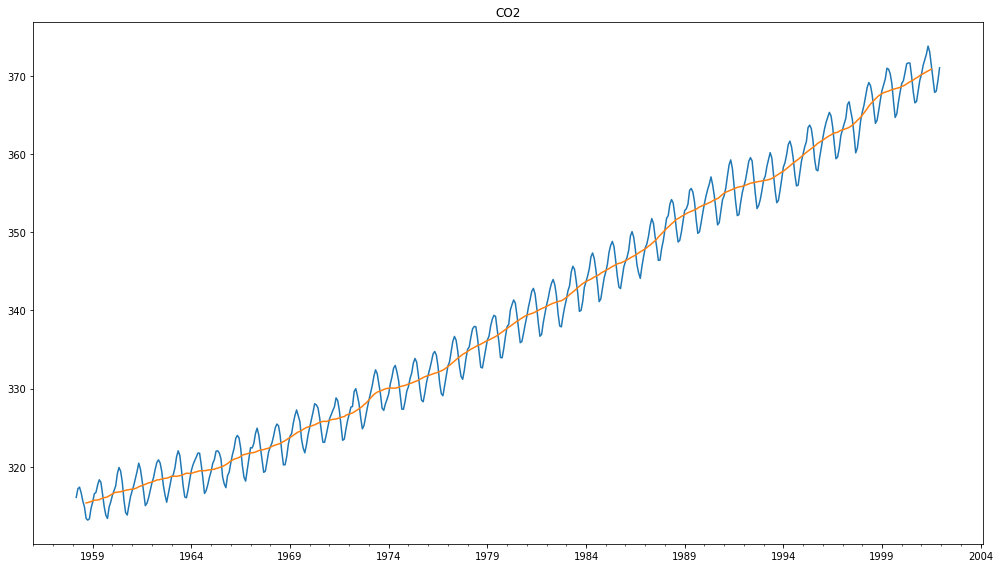

In [10]:
co2_series = df_co2ms.loc[:,'co2']
rolling_mean(co2_series, window=12, title="CO2")

In [11]:
def rolling_bands(tseries, nstd=2, window=30, title='', figsize=(14, 8)):
    '''Plot a time series along with its rolling mean and 2 std'''
    fig = plt.figure(figsize=figsize)
    ts_ax = tseries.plot()
    ts_ax.set_title(title)
    roll = tseries.rolling(window, center=True)
    m = roll.agg(['mean', 'std'])
    m['mean'].plot(ax=ts_ax)
    s = nstd * m['std']
    ts_ax.fill_between(m.index, m['mean'] - s, m['mean'] + s, alpha=0.25)
    plt.tight_layout()
    sns.despine()

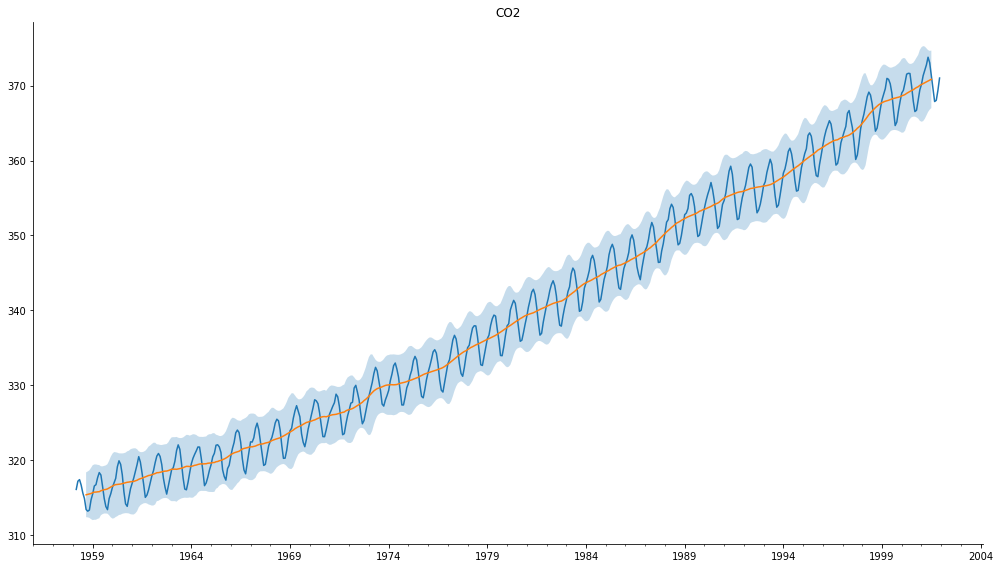

In [12]:
rolling_bands(co2_series, window=12, title="CO2")

The series appears to have a yearly cycle.  Let's look at a variety of methods to see the components of this time series.  We will start with plotting each month of the year separately (but on the same graph).

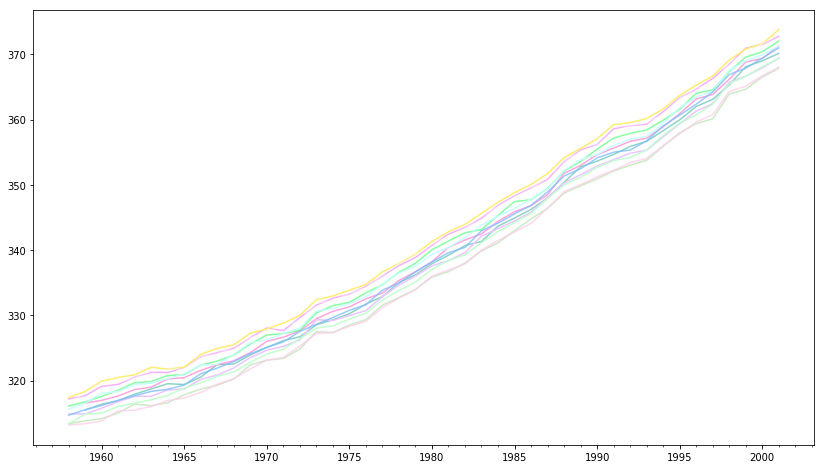

In [13]:
month_colors = plt.cm.Set3(np.linspace(0, 1, 12))
grouped = df_co2ms.groupby(lambda x: x.month)
for month, group in grouped:
    ax = group.loc[:,'co2'].plot(color=month_colors, figsize=(14,8))
    month_colors = np.roll(month_colors, 1)
plt.show()

Now with the original graph plotted on top of the monthly plots ...

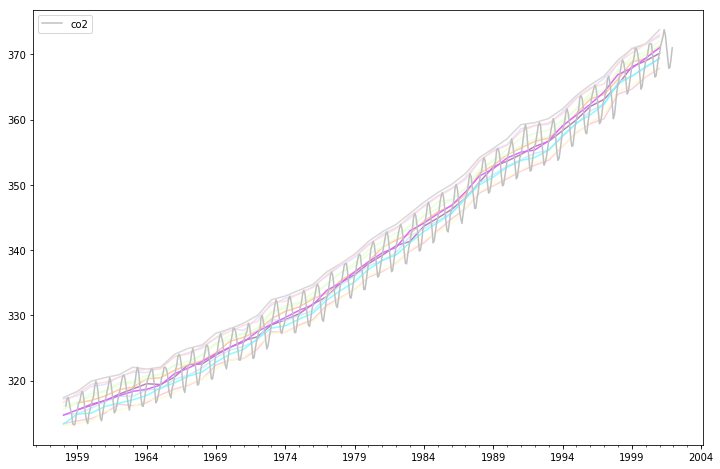

In [14]:
for month, group in grouped:
    ax = group.loc[:,'co2'].plot(color=month_colors, figsize=(12,8))
    month_colors = np.roll(month_colors, 1)
df_co2ms.plot(color='silver', ax=ax)
plt.show()

Here's another way to see the trend and variation.  Let's group the data by year and then place a box plot onto the graph for each year.

In [15]:
df_co2ms["Dates"] = df_co2ms.index
df_co2ms["Years"] = df_co2ms.index.year
df_co2ms["Months"] = df_co2ms.index.month
df_co2ms.head()

,co2,Dates,Years,Months
1958-03-01,316.100,1958-03-01,1958,3
1958-04-01,317.200,1958-04-01,1958,4
1958-05-01,317.410,1958-05-01,1958,5
1958-06-01,316.675,1958-06-01,1958,6
1958-07-01,315.625,1958-07-01,1958,7


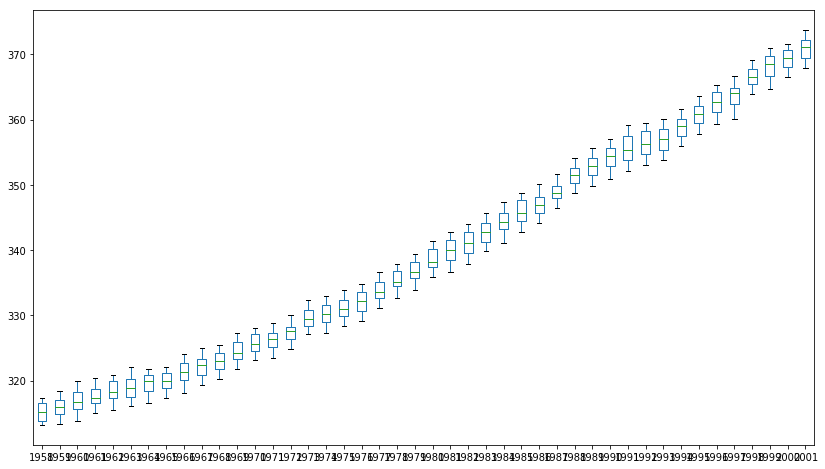

In [16]:
df_yearly = df_co2ms.pivot(index='Dates', columns='Years', values='co2')
df_yearly.plot.box(figsize=(14,8))
plt.show()

### Box Plots

A seasonal subseries box plot is a useful tool when looking for the variation with each cycle.  Box plots are good for answering the following questions:

* Is a factor significant?
* Does the location differ between subgroups?
* Does the variation differ between subgroups?
* Are there any outliers?

#### Outliers
The box portion of the box plot represents the first quartile (Q1), the second quartile or median (Q2) and the third quartile.  If a point is less than Q1 - 1.5 times (Q3 - Q1), then it is considered an outlier.  If it is less than Q1 - 3.0 times (Q3 - Q1), then it is a strong outlier.  Similarly, if a point is more than Q3 + 1.5 times (Q3 - Q1), then it is an outlier.  If it is more than Q3 + 3.0 times (Q3 - Q1), then it is a strong outlier.

Let's group the dataframe into months and create a box plot for each month to see what this shows us.

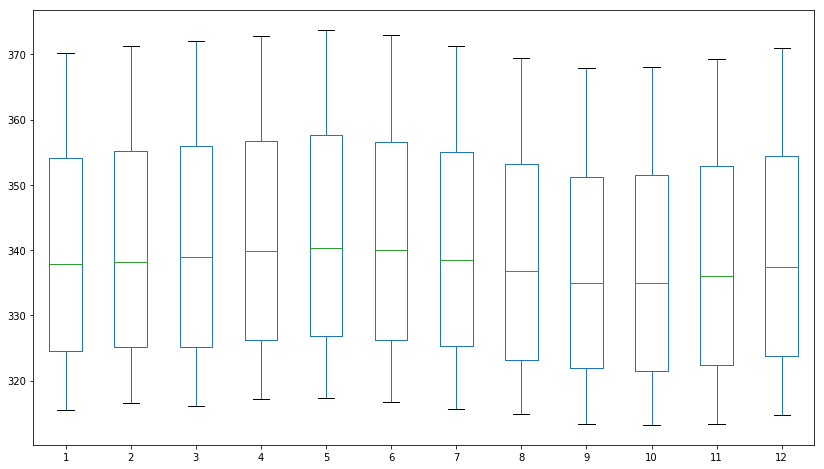

In [17]:
df_monthly = df_co2ms.pivot(index='Dates', columns='Months', values='co2')
df_monthly.plot.box(figsize=(14,8))
plt.show()

> Note: I suspect there is a better way to do some of these subseries plots.  If you come up with cleaner more flexible ways to do these plots, then please share your approach with the rest of us.

### The Statsmodel Seasonal Subseries Plots
Statsmodels provides a seasonal plot, quarter plot and a month plot.  However, for some reason the values inside of each bin are sorted.  Therefore, the seasonal subseries plots produced by statsmodels will not match those produced by other software.

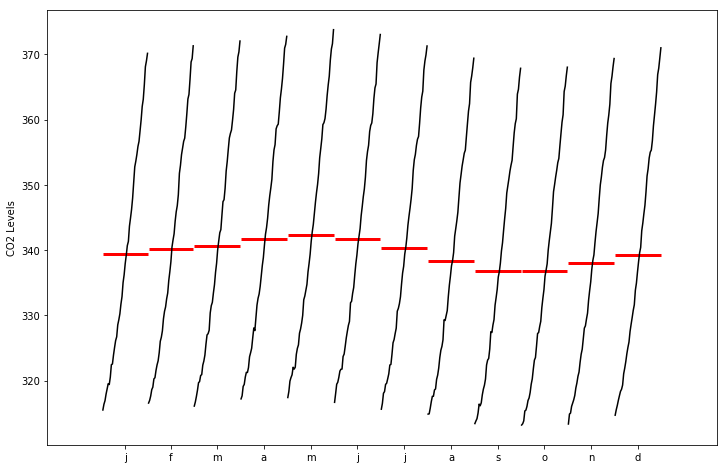

In [18]:
co2_series = pd.Series(data=df_co2ms.loc[:, 'co2'], index=df_co2ms.index)
fig = sm.graphics.tsa.month_plot(df_co2ms['co2'], ylabel='CO2 Levels')
fig.set_size_inches(2*fig.get_figwidth(), 2*fig.get_figheight())
plt.show()

### Statsmodel Seasonal Decompose

Statsmodel provides a seasonal decompose function.  It is a reasonable starting point for exploration, but it is a "naive decomposition".  For modeling and forecasting, more sophisticated approaches should be considered.

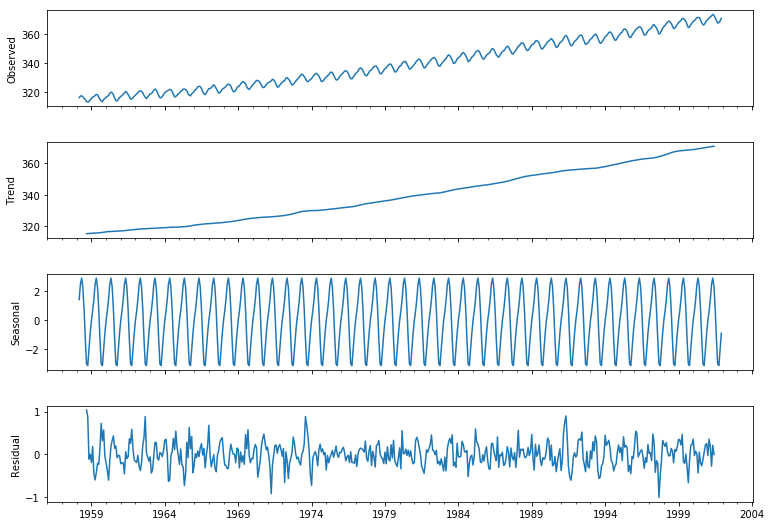

In [19]:
co2_decomposition = smt.seasonal_decompose(co2_series, model='additive')
fig = co2_decomposition.plot()
fig.set_size_inches(2*fig.get_figwidth(), 2*fig.get_figheight())
plt.show()

(2, 526)


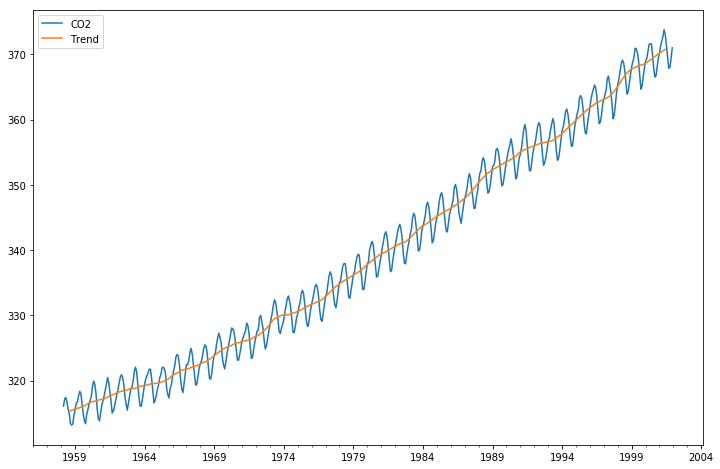

In [20]:
col1 = co2_series.values
col2 = co2_decomposition.trend
data = np.array([col1, col2])
print(data.shape)
df2 = pd.DataFrame(data=data.T, columns=['CO2', 'Trend'], index=co2_series.index)
df2.plot(figsize=(12,8))

Let's detrend the time series and look at the remaining series (which includes the seasonal component).  We will plot the rolling mean and the rolling standard deviation to guage how likely it is that this new series is stationary.

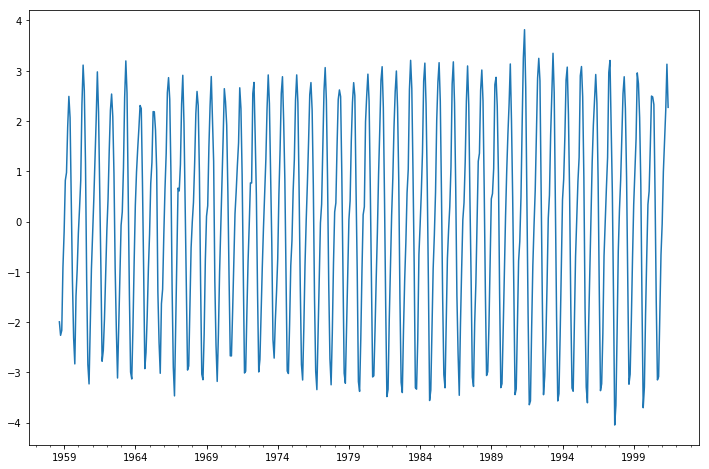

In [21]:
co2_detrended = co2_series - co2_decomposition.trend
co2_detrended.plot(figsize=(12,8))

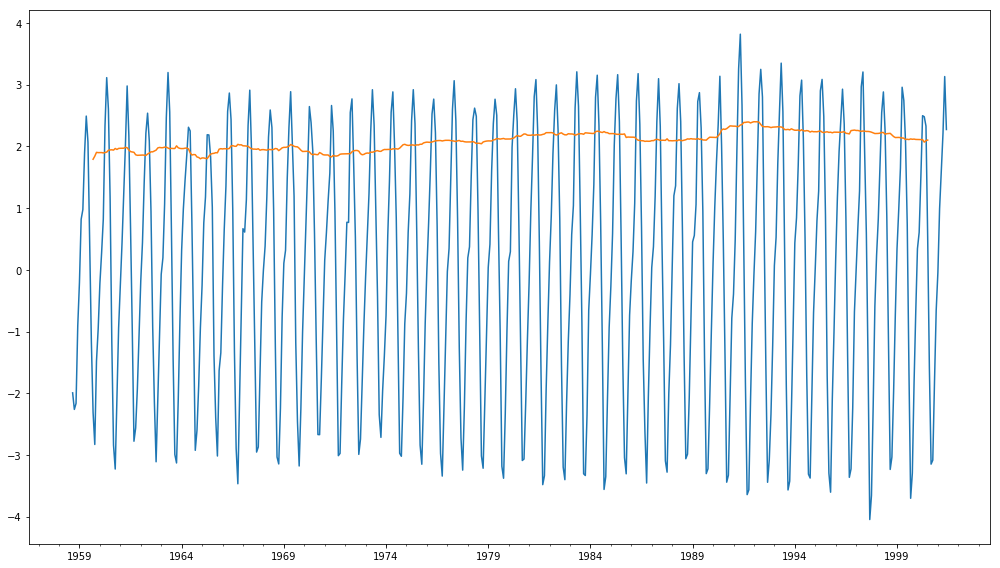

In [22]:
rolling_std(co2_detrended, window=24)

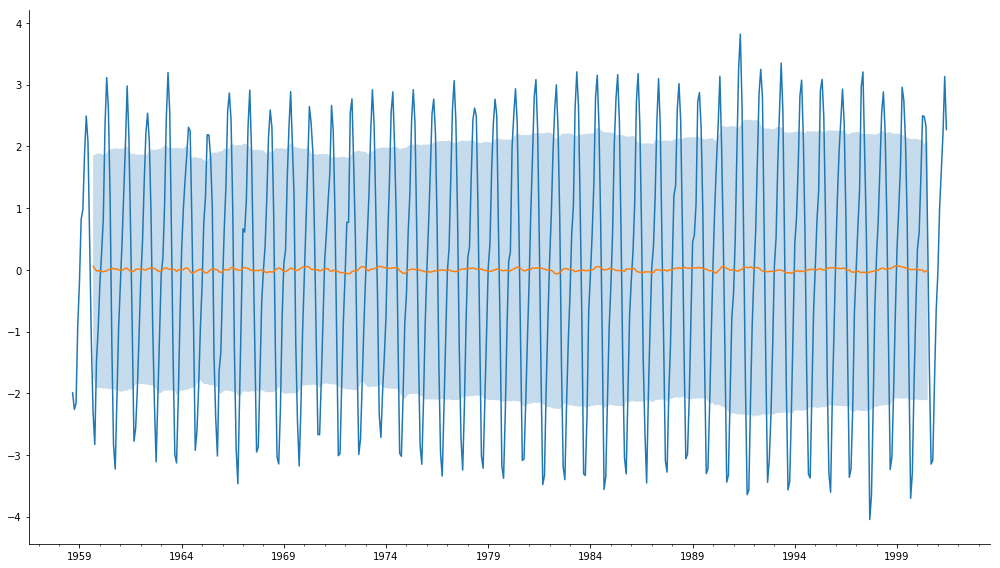

In [23]:
rolling_bands(co2_detrended, nstd=1, window=24)

The series seems to have (approximately) a zero mean and a steady standard deviation.  Now let's explore the detrended series using some new tools.

First, notice that the start and end dates of the detrended series do not match the start and end dates of the original series.  (Why are there missing data points?  Is the number of missing data points what you would expect?)

Pandas handles the NaNs seamlessly, but statsmodels and most other modules do not.  Therefore, any series that will be passed into a non-Pandas function should have the NaNs removed.

In [24]:
co2_series.describe()

count    526.000000
mean     339.617517
std       17.117494
min      313.194444
25%      324.025000
50%      337.912500
75%      354.537500
max      373.800000
Name: co2, dtype: float64

In [25]:
co2_detrended.describe()

count    514.000000
mean       0.003140
std        2.039781
min       -4.046042
25%       -1.718281
50%        0.320844
75%        1.873829
max        3.816667
Name: co2, dtype: float64

In [26]:
co2_detrended.head(10)

1958-03-01         NaN
1958-04-01         NaN
1958-05-01         NaN
1958-06-01         NaN
1958-07-01         NaN
1958-08-01         NaN
1958-09-01   -1.993623
1958-10-01   -2.262199
1958-11-01   -2.164491
1958-12-01   -0.911019
Freq: MS, Name: co2, dtype: float64

In [27]:
co2_detrended_trimmed = co2_detrended.dropna()
co2_detrended_trimmed.head()

1958-09-01   -1.993623
1958-10-01   -2.262199
1958-11-01   -2.164491
1958-12-01   -0.911019
1959-01-01   -0.204769
Freq: MS, Name: co2, dtype: float64

## Lag Plot

A lag plot helps identify whether or not the time series is random or has some underlying structure.  A non-random structure in the lag plot is highly indicative that the time series was produced by a non-random process. 

Pandas suppliesthe lag plot "out of the box", so it is worth a quick try.  If the lag plot shows some structure to it, then there is some self correlation in the time series.

Let's try the lag plot on both the detrended data and on the residual of the decomposed model (to give an idea of how well the seasonal decomposition performed).

#### Detrended Series

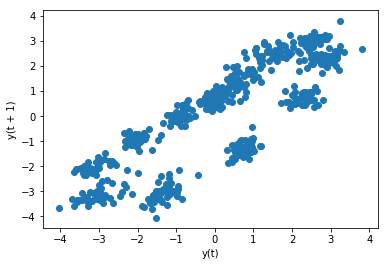

In [28]:
pd.plotting.lag_plot(co2_detrended_trimmed)

There is an obvious structure to the lag plot.  This is as expected, given the cycles we see in the time series.

#### Residual Series
The residuals from the seasonal decomposition look rather random.  Are they?  Let's check the lag plot of the residuals.

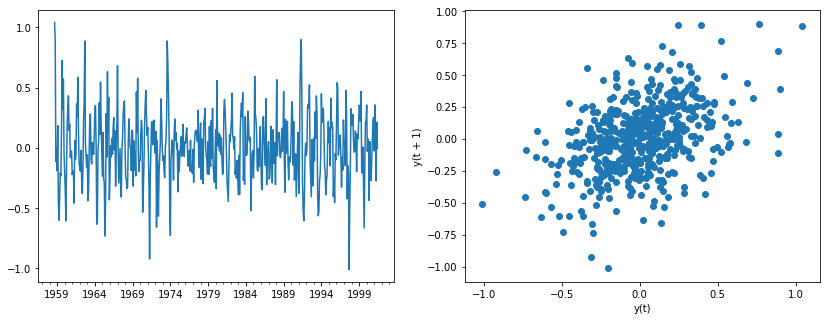

In [29]:
fig = plt.figure(figsize=(14,5))
layout = (1, 2)
ts_ax   = plt.subplot2grid(layout, (0, 0))
resid_ax = plt.subplot2grid(layout, (0, 1))
co2_decomposition.resid.plot(ax=ts_ax)
pd.plotting.lag_plot(co2_decomposition.resid, ax=resid_ax)
plt.show()

The lag plot shows that the residual time series from the seasonal decomposition has a little bit of structure left in it.  Therefore, one should expect to be able to improve upon the "naive" seasonal decomposition model produced "out of the box" by statsmodels.

Two powerful tools are the Autocorrelation Plot and the Partial Autocorrelation plot.  These two plots, when used together can help identify whether or not the time series is representable by an autoregressive model or a moving average model.

The autocorrelation plot gives us information about whether or not the time series follows and autoregressive or moving average model.  If there is no significant correlation or the correlation does not die down to zero (as in a sinusoidal model), then an ARMA model is inappropriate for the data.  If the autocorrelation model decays towards zero, then the combination of the autocorrelation model and the partial autocorrelation model can give information about what model orders to try first.

### ARMA Models
<br>
$$ Y_t = K + a_1 X_{t-1} + ... + a_p X_{t-p} +
         W_t - \theta_1 W_{t-1} - ... - \theta_q W_{t-q}$$
<br>
where
$$ K = (1 - \sum_{i=1}^{p} a_i) \mu $$

### Manual ARMA Modeling Procedure

* Remove Trend and Seasonality
* Check for Stationarity
 * If not stationary, difference until have a stationary time series and/or add a seasonal component to the model and/or transform the model
* Identify the AR order (p) and the MA order (q)
 * Use Autocorrelation and Partial Autocorrelation Plots
    
#### Autocorrelation Plot

| Shape | Model |
|-------|-------|
| Exponential Decay to zero | AR(p).  Choose p where PACF becomes zero. |
| Alternating decay to zero | AR(p).  Choose p where PACF becomes zero. |
| Decay after a few lags    | ARMA model                                |
| Some spikes, rest zero    | MA(q).  Choose q where ACF becomes zero.  |
| All zero                  | Random data...white noise.                |
| High Periodic Values      | Include a seasonal AR term.               |
| No decay to zero          | Series is not stationary.                 |

#### Partial Autocorrelation Plot

| Shape | Model |
|-------|-------|
| Exponential Decay to zero | MA(q).  Choose q where ACF becomes zero.  |
| Alternating decay to zero | MA(q).  Choose q where ACF becomes zero.  |
| Some spikes, rest zero    | AR(p).  Choose p where PACF becomes zero. |

The Autocorrelation plot and the Partial Autocorrelation plot will have bounds (dashed lines or a shaded area) indicating a region where the values can (statistically) be considered to be zero.

#### SIDE NOTES:
* ARMA models with seasonal components are called SARMA models.
* ARMA models with differencing are called ARIMA models.

In [30]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax


Let's generate the Autocorrelation plot and the Partial Autocorrelation plot for the detrended CO2 time series to see what these plots tell us about this time series.

(<matplotlib.axes._subplots.AxesSubplot at 0x1f1feb625f8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f1fe2c0780>)

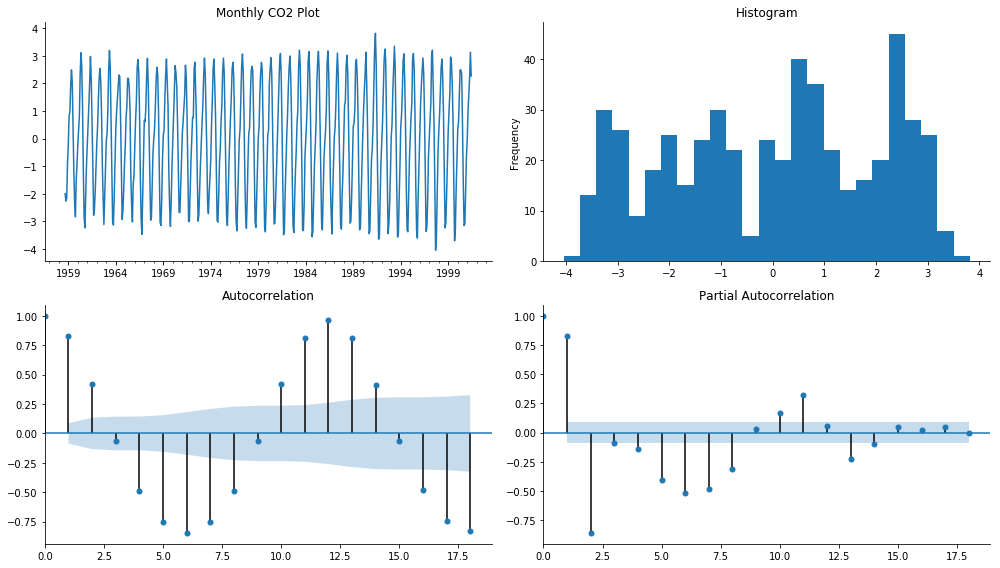

In [31]:
tsplot(co2_detrended_trimmed, lags=18, title='Monthly CO2 Plot')

Notice that the Autocorrelation plot above does not appear to be decreasing.  The value at lag 6 is equal to the value at lag 18.  This indicates that an ARMA model is not appropriate for this time series.  We should consider using either a sinusoidal model or a seasonal ARMA model with a seasonal period of 12.

Next let's look at the Autocorrelation Plot and the Partial Autocorrelation Plot for the residuals from the seasonal decomposition produced by statsmodels.  Don't forget to drop the "Not Available" values in the residual or your ACF and PACF plots will be empty.  (Statsmodels--the module used here to produce the ACF and PACF plots--does not handle NaN values as well as Pandas.)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f1fe3a9860>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f1fecdaa58>)

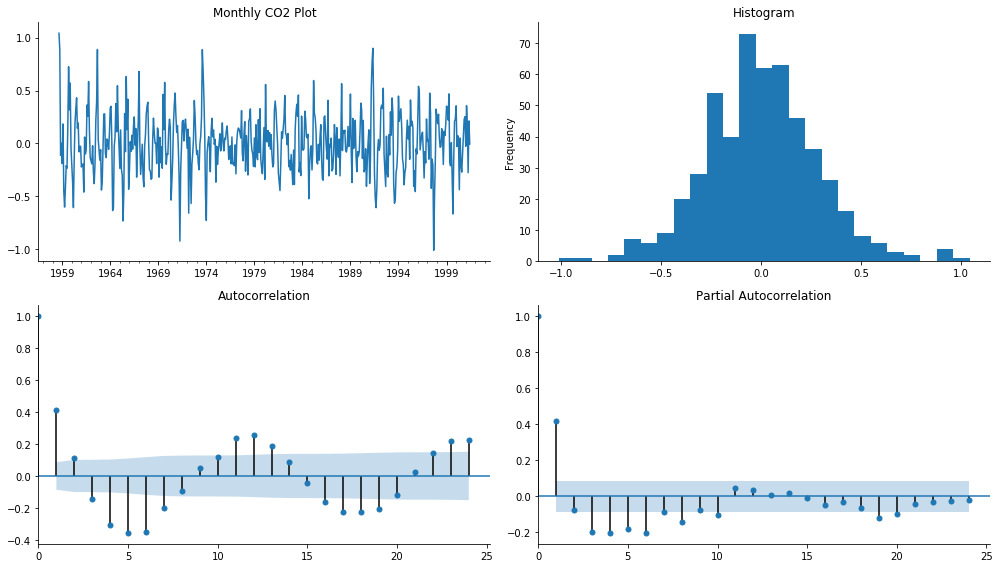

In [32]:
tsplot(co2_decomposition.resid.dropna(), lags=24, title='Monthly CO2 Plot')

Even though the plot of the residuals looks rather random, the plot of the Autocorrelation Function indicates that there is still some structure left in these residuals.

## Spectral Plot

Spectral plots are often used as a starting point to finding the underlying frequency in a sinusoidal model.  In order to be effective, spectral plots require a zero mean and a cyclic pattern with a constant period (preferably with a constant variance, too).
Lets plot the power spectral density function.  The input will be the detrended (and trimmed) CO2 series, the sampling frequency is 12 times per year, and we will set the number of points to use in the FFT (for calculating the DFT) to 512 (a power of 2, close to the length of the series).

In [33]:
frequencies, psd_samples = signal.periodogram(co2_detrended_trimmed, fs=12.0, nfft=512, return_onesided=True, scaling='spectrum')
power = np.sum(psd_samples)
series_variance = co2_detrended_trimmed.var()
print("Sum Power Spectrum = {}".format(power))
print("Variance of Data = {}".format(series_variance))

Sum Power Spectrum = 4.139571796278624
Variance of Data = 4.160707560436375


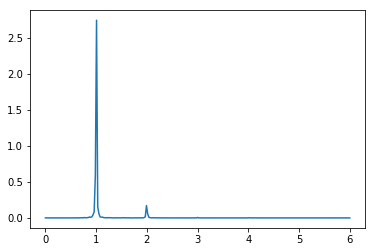

In [34]:
psd_series = pd.Series(data=psd_samples, index=frequencies)
psd_series.plot()